In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [9]:
print("Loading Instacart data...")

orders = pd.read_csv("../data/raw/orders.csv")
prior = pd.read_csv("../data/raw/order_products__prior.csv")
products = pd.read_csv("../data/raw/products.csv")
aisles = pd.read_csv("../data/raw/aisles.csv")
departments = pd.read_csv("../data/raw/departments.csv")

print(f"Orders: {orders.shape}")
print(f"Prior order products: {prior.shape}")
print(f"Products: {products.shape}")
print(f"Aisles: {aisles.shape}")
print(f"Departments: {departments.shape}")

Loading Instacart data...
Orders: (3421083, 7)
Prior order products: (32434489, 4)
Products: (49688, 4)
Aisles: (134, 2)
Departments: (21, 2)


In [10]:
print("\n" + "=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

# Check missing values
print("\nMissing Values:")
print("orders:")
print(orders.isnull().sum())
print("\nprior:")
print(prior.isnull().sum())
print("\nproducts:")
print(products.isnull().sum())

# Check duplicates
print(f"\nDuplicate orders: {orders.duplicated().sum()}")
print(f"Duplicate products: {products.duplicated().sum()}")


DATA QUALITY CHECKS

Missing Values:
orders:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

prior:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

products:
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

Duplicate orders: 0
Duplicate products: 0


In [11]:
print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# 1. User behavior
user_stats = (
    orders.groupby('user_id')
    .agg({
        'order_id': 'count',
        'days_since_prior_order': 'mean'
    })
    .rename(columns={'order_id': 'total_orders'})
)

print("\nUser Statistics:")
display(user_stats.describe())


EXPLORATORY DATA ANALYSIS

User Statistics:


,total_orders,days_since_prior_order
count,206209.000000,206209.000000
mean,16.590367,15.448686
std,16.654774,6.915575
min,4.000000,0.000000
25%,6.000000,9.814815
50%,10.000000,15.000000
75%,20.000000,20.625000
max,100.000000,30.000000


In [12]:
# 2. Product popularity
product_stats = (
    prior.groupby('product_id')
    .agg({
        'order_id': 'nunique',
        'reordered': 'sum'
    })
    .rename(columns={'order_id': 'order_count', 'reordered': 'reorder_count'})
)

product_stats = product_stats.merge(products, on='product_id', how='left')

print("\nTop 20 Most Popular Products:")
display(product_stats.nlargest(20, 'order_count')[['product_name', 'order_count', 'reorder_count']])

# 3. Reorder rate
overall_reorder_rate = prior['reordered'].mean()
print(f"\nOverall Reorder Rate: {overall_reorder_rate:.2%}")

# 4. Basket size
basket_size = prior.groupby('order_id').size()
print(f"\nAverage Basket Size: {basket_size.mean():.2f} items")
print(f"Median Basket Size: {basket_size.median():.0f} items")


Top 20 Most Popular Products:


,product_name,order_count,reorder_count
24848,Banana,472565,398609
13172,Bag of Organic Bananas,379450,315913
21133,Organic Strawberries,264683,205845
21899,Organic Baby Spinach,241921,186884
47198,Organic Hass Avocado,213584,170131
47755,Organic Avocado,176815,134044
47615,Large Lemon,152657,106255
16793,Strawberries,142951,99802
26204,Limes,140627,95768
27839,Organic Whole Milk,137905,114510



Overall Reorder Rate: 58.97%

Average Basket Size: 10.09 items
Median Basket Size: 8 items


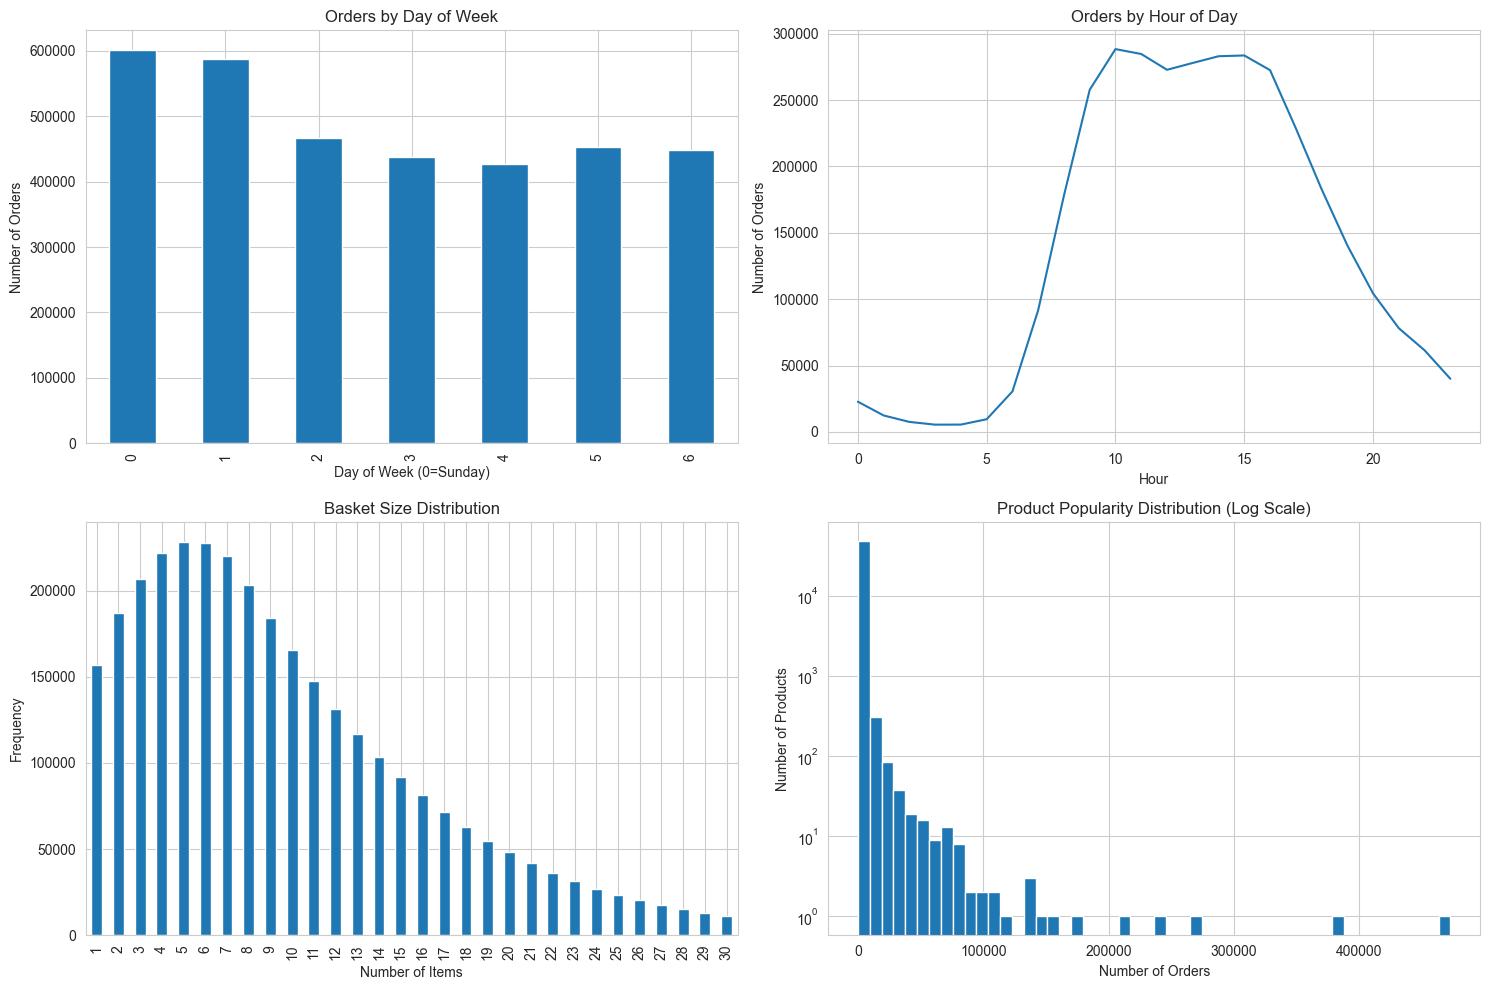


✓ EDA complete. Visualizations saved to metrics/eda_overview.png


In [13]:
# ===================== Visualizations =====================
import os
os.makedirs("metrics", exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Orders by day of week
orders['order_dow'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Orders by Day of Week')
axes[0, 0].set_xlabel('Day of Week (0=Sunday)')
axes[0, 0].set_ylabel('Number of Orders')

# 2. Orders by hour of day
orders['order_hour_of_day'].value_counts().sort_index().plot(kind='line', ax=axes[0, 1])
axes[0, 1].set_title('Orders by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Number of Orders')

# 3. Basket size distribution (top 30 sizes)
basket_size.value_counts().head(30).sort_index().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Basket Size Distribution')
axes[1, 0].set_xlabel('Number of Items')
axes[1, 0].set_ylabel('Frequency')

# 4. Product popularity distribution (log scale)
# NOTE: in earlier cell we named it product_stats. Make sure it exists.
product_stats['order_count'].plot(kind='hist', bins=50, ax=axes[1, 1], logy=True)
axes[1, 1].set_title('Product Popularity Distribution (Log Scale)')
axes[1, 1].set_xlabel('Number of Orders')
axes[1, 1].set_ylabel('Number of Products')

plt.tight_layout()
plt.savefig('metrics/eda_overview.png', dpi=300)
plt.show()

print("\n✓ EDA complete. Visualizations saved to metrics/eda_overview.png")